In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.modules.distribution_output import NegativeBinomialOutput

from pts.dataset.repository.datasets import dataset_recipes

from pytorch_lightning.loggers import CSVLogger

from vq_ar import VQVAEEstimator, ImplicitQuantileNetworkOutput, QuantileLoss 

In [4]:
dataset = get_dataset("wiki-rolling_nips")

In [5]:
estimator = VQVAEEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        dec_rnn_hidden_size=64,
    
        vq_embedding_dim=128,
        vq_num_embedding=256,
        vq_jitter_prob=None,
    
        scaling=True,
    
        batch_size=64,
        num_batches_per_epoch=200,
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        embedding_dimension=[16],
        
        #distr_output=NegativeBinomialOutput(),
        distr_output=ImplicitQuantileNetworkOutput("positive"),
        loss=QuantileLoss(),
    
        trainer_kwargs=dict(gpus="1", max_epochs=100, logger=CSVLogger(".", "lightning_logs/")),
    )

In [6]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=4,
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:321: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:321: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:321: FutureWarning: The 'freq' argument in Timestamp is deprecated an

Training: 0it [00:00, ?it/s]

Epoch 0, global step 199: train_loss reached 523.06921 (best 523.06921), saving model to "./lightning_logs/version_179/checkpoints/epoch=0-step=199.ckpt" as top 1
Epoch 1, global step 399: train_loss reached 329.87711 (best 329.87711), saving model to "./lightning_logs/version_179/checkpoints/epoch=1-step=399.ckpt" as top 1
Epoch 2, global step 599: train_loss reached 309.72455 (best 309.72455), saving model to "./lightning_logs/version_179/checkpoints/epoch=2-step=599.ckpt" as top 1
Epoch 3, global step 799: train_loss reached 268.95999 (best 268.95999), saving model to "./lightning_logs/version_179/checkpoints/epoch=3-step=799.ckpt" as top 1
Epoch 4, global step 999: train_loss reached 259.12369 (best 259.12369), saving model to "./lightning_logs/version_179/checkpoints/epoch=4-step=999.ckpt" as top 1
Epoch 5, global step 1199: train_loss reached 258.99988 (best 258.99988), saving model to "./lightning_logs/version_179/checkpoints/epoch=5-step=1199.ckpt" as top 1
Epoch 6, global step

Epoch 99, global step 19999: train_loss was not in top 1


In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [8]:
forecasts = list(forecast_it)

/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:321: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:325: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/sr

In [9]:
tss = list(ts_it)

In [10]:
evaluator = Evaluator()

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 47675it [00:00, 121739.79it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.fre

In [12]:
agg_metrics # iqn 100 epochs 

{'MSE': 37148947.86337017,
 'abs_error': 1104926645.3728485,
 'abs_target_sum': 4139290389.0,
 'abs_target_mean': 2894.1027016255903,
 'seasonal_error': 759.9957754325233,
 'MASE': 1.2611428171539982,
 'MAPE': 0.24222429549416924,
 'sMAPE': 0.20826330206398783,
 'MSIS': 22.098281448234335,
 'QuantileLoss[0.1]': 423928447.7681832,
 'Coverage[0.1]': 0.25114700227233,
 'QuantileLoss[0.2]': 659651073.5533782,
 'Coverage[0.2]': 0.35375983219716833,
 'QuantileLoss[0.3]': 845956031.5709118,
 'Coverage[0.3]': 0.43761160636252405,
 'QuantileLoss[0.4]': 993465392.5828003,
 'Coverage[0.4]': 0.5129389966789023,
 'QuantileLoss[0.5]': 1104926647.01305,
 'Coverage[0.5]': 0.5837329138262541,
 'QuantileLoss[0.6]': 1175800796.29013,
 'Coverage[0.6]': 0.6458003845481559,
 'QuantileLoss[0.7]': 1206132956.965562,
 'Coverage[0.7]': 0.715271456039154,
 'QuantileLoss[0.8]': 1177055988.3296995,
 'Coverage[0.8]': 0.7874308687292432,
 'QuantileLoss[0.9]': 1043322237.0847218,
 'Coverage[0.9]': 0.8676902639398706,

In [13]:
agg_metrics # iqn 50 epochs 

{'MSE': 42864173.49141814,
 'abs_error': 1171192639.8383179,
 'abs_target_sum': 4139290389.0,
 'abs_target_mean': 2894.1027016255903,
 'seasonal_error': 759.9957754325233,
 'MASE': 1.3228403828654438,
 'MAPE': 0.27950360955772774,
 'sMAPE': 0.21309433929533875,
 'MSIS': 23.38297169058881,
 'QuantileLoss[0.1]': 412677043.7762253,
 'Coverage[0.1]': 0.16306170249956303,
 'QuantileLoss[0.2]': 666512873.4264038,
 'Coverage[0.2]': 0.27233210977101907,
 'QuantileLoss[0.3]': 872728579.3836753,
 'Coverage[0.3]': 0.3790505156441182,
 'QuantileLoss[0.4]': 1040575519.66736,
 'Coverage[0.4]': 0.48398112218143685,
 'QuantileLoss[0.5]': 1171192639.0293617,
 'Coverage[0.5]': 0.5865142457612306,
 'QuantileLoss[0.6]': 1253200782.6612854,
 'Coverage[0.6]': 0.6756790770844258,
 'QuantileLoss[0.7]': 1295982227.7475219,
 'Coverage[0.7]': 0.7682398182135991,
 'QuantileLoss[0.8]': 1275016523.5778184,
 'Coverage[0.8]': 0.8502219891627338,
 'QuantileLoss[0.9]': 1140297899.1585097,
 'Coverage[0.9]': 0.9190050690

In [31]:
agg_metrics # iqn 100 epochs 

{'MSE': 37768260.90774697,
 'abs_error': 1114498176.339096,
 'abs_target_sum': 4139290389.0,
 'abs_target_mean': 2894.1027016255903,
 'seasonal_error': 759.9957754325233,
 'MASE': 1.2489954157392997,
 'MAPE': 0.23991665343966562,
 'sMAPE': 0.2070113199081814,
 'MSIS': 22.1067249540944,
 'QuantileLoss[0.1]': 411788822.2616494,
 'Coverage[0.1]': 0.21644467750393287,
 'QuantileLoss[0.2]': 650992401.747036,
 'Coverage[0.2]': 0.31118685544485225,
 'QuantileLoss[0.3]': 842362662.2903675,
 'Coverage[0.3]': 0.39166159762279323,
 'QuantileLoss[0.4]': 996144982.6553646,
 'Coverage[0.4]': 0.4663499388218843,
 'QuantileLoss[0.5]': 1114498177.0847168,
 'Coverage[0.5]': 0.5392106275126727,
 'QuantileLoss[0.6]': 1191532291.5964394,
 'Coverage[0.6]': 0.6053633980073415,
 'QuantileLoss[0.7]': 1228918858.2751617,
 'Coverage[0.7]': 0.681869603216221,
 'QuantileLoss[0.8]': 1206097870.8615615,
 'Coverage[0.8]': 0.7647425275301521,
 'QuantileLoss[0.9]': 1075707350.7546105,
 'Coverage[0.9]': 0.85752910330361

In [12]:
agg_metrics # nb 100 epochs 

{'MSE': 52557857.84294446,
 'abs_error': 1216757848.0,
 'abs_target_sum': 4139290389.0,
 'abs_target_mean': 2894.1027016255903,
 'seasonal_error': 759.9957754325233,
 'MASE': 1.3557575318566883,
 'MAPE': 0.2931828762681058,
 'sMAPE': 0.22584330040032036,
 'MSIS': 25.374743078969964,
 'QuantileLoss[0.1]': 369846072.6,
 'Coverage[0.1]': 0.05759692361475267,
 'QuantileLoss[0.2]': 625644659.5999999,
 'Coverage[0.2]': 0.1533032686593253,
 'QuantileLoss[0.3]': 841506255.0,
 'Coverage[0.3]': 0.2823282642894599,
 'QuantileLoss[0.4]': 1037838077.2,
 'Coverage[0.4]': 0.4266079356755812,
 'QuantileLoss[0.5]': 1216757848.0,
 'Coverage[0.5]': 0.5645110994581367,
 'QuantileLoss[0.6]': 1354512897.1999998,
 'Coverage[0.6]': 0.6737668239818213,
 'QuantileLoss[0.7]': 1460633774.6000001,
 'Coverage[0.7]': 0.7751337178814892,
 'QuantileLoss[0.8]': 1497644344.3999999,
 'Coverage[0.8]': 0.855946862436637,
 'QuantileLoss[0.9]': 1391925592.5999997,
 'Coverage[0.9]': 0.9204810347841287,
 'RMSE': 7249.679844168

In [13]:
agg_metrics

{'MSE': 49818088.43445495,
 'abs_error': 1332073694.0,
 'abs_target_sum': 4139290389.0,
 'abs_target_mean': 2894.1027016255903,
 'seasonal_error': 759.9957754325233,
 'MASE': 1.4744654747629276,
 'MAPE': 0.3198218410064282,
 'sMAPE': 0.259978853568604,
 'MSIS': 30.105092218227632,
 'QuantileLoss[0.1]': 411813750.40000004,
 'Coverage[0.1]': 0.09939311309211678,
 'QuantileLoss[0.2]': 702685193.6,
 'Coverage[0.2]': 0.22084880265687817,
 'QuantileLoss[0.3]': 947165482.2,
 'Coverage[0.3]': 0.3611683272155218,
 'QuantileLoss[0.4]': 1157255871.2,
 'Coverage[0.4]': 0.4998112218143681,
 'QuantileLoss[0.5]': 1332073694.0,
 'Coverage[0.5]': 0.6260520887956651,
 'QuantileLoss[0.6]': 1449576190.8,
 'Coverage[0.6]': 0.725396958573676,
 'QuantileLoss[0.7]': 1532021436.8000002,
 'Coverage[0.7]': 0.817558468799161,
 'QuantileLoss[0.8]': 1561268062.8,
 'Coverage[0.8]': 0.8893871700751619,
 'QuantileLoss[0.9]': 1514579265.5999997,
 'Coverage[0.9]': 0.9422247858765951,
 'RMSE': 7058.193000652146,
 'NRMSE'

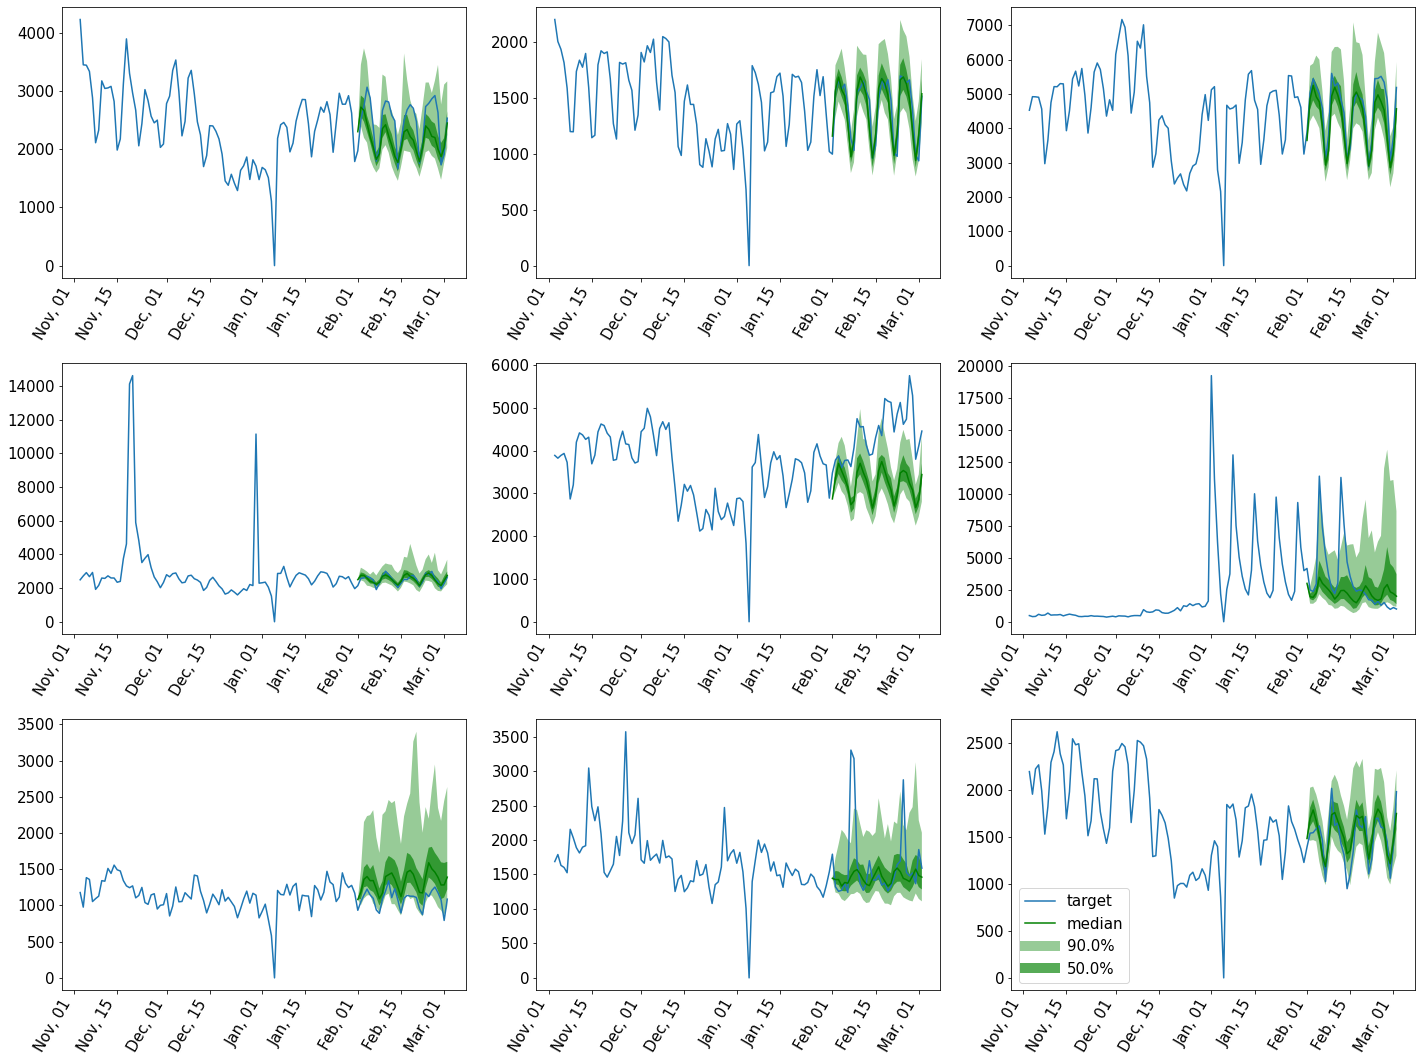

In [32]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [33]:
metrics = pd.read_csv("lightning_logs/version_122/metrics.csv")

In [34]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,1.044558,0,49,NaN,NaN
1,1.871328,0,99,NaN,NaN
2,3.576301,0,149,NaN,NaN
3,3.662716,0,199,NaN,NaN
4,NaN,0,199,305.272919,NaN
...,...,...,...,...,...
595,109.776947,99,19899,NaN,NaN
596,109.252701,99,19949,NaN,NaN
597,107.523987,99,19999,NaN,NaN
598,NaN,99,19999,192.726181,NaN


Text(0, 0.5, 'perplexity')

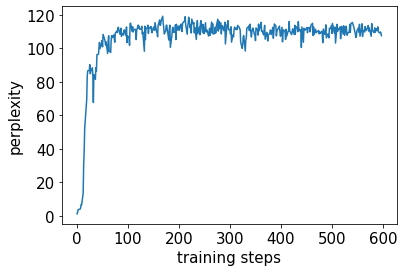

In [35]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

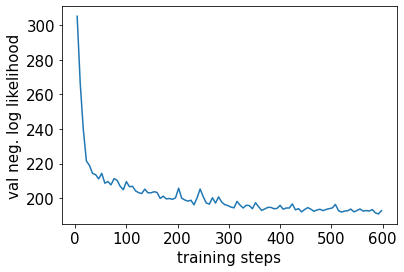

In [36]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [37]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [38]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

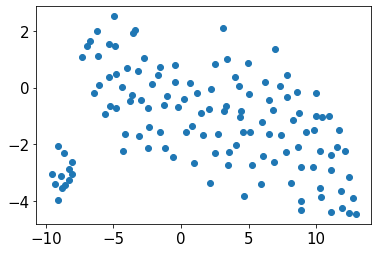

In [39]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)